In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from skopt import BayesSearchCV
from skopt.space import (
    Real, 
    Categorical, 
    Integer
)

import RecursiveFeatureSelector

import pickle

import itertools

from soccer_util import (
    who_won, 
    get_streak, 
    get_count, 
    get_match_count,
    get_match_specific_streak, 
    get_match_specific_count, 
    get_match_specific_match_count, 
    get_match_specific_pct,
    get_odd_ratio,
    get_ewm,
    get_match_specific_ewm,
    encode
)


In [15]:
df = pd.read_csv("dataframes/results/premier_league.csv")
df = df[['match_name', 'result', 'h_odd', 'd_odd', 'a_odd', 'n_bookmakers_odd', 'datetime', 'season']]

In [16]:
df = df[df.h_odd != '-'].copy()
df = df[df.a_odd != '-'].copy()
df = df[df.d_odd != '-'].copy()

# get 'home_team' and 'away_home' by splitting 'match_name'
df['home_team'] = df.match_name.apply(lambda x: x.split("-")[0].strip(" "))
df['away_team'] = df.match_name.apply(lambda x: x.split("-")[1].strip(" "))

# remove postponed matches
df = df[~(df.result == "postp.")].copy()

# get feature 'home_score' and 'away_score'
df['home_score'] = df.result.apply(lambda x: x.split(":")[0])
df['away_score'] = df.result.apply(lambda x: x.split(":")[1])


# get target 'winner'
df['winner'] = df.result.apply(who_won)


df = get_match_specific_match_count(df)
for i in ['home', 'away']:
    df = get_match_count(df, i)
    for j in ['win', 'lose', 'draw']:
        df = get_streak(df, i, j)
        df = get_count(df, i, j)
        df = get_match_specific_streak(df, i, j)
        df = get_match_specific_count(df, i, j)
        df = get_match_specific_pct(df, i, j)       
        
for k in ['home', 'away']:
    for l in ['home', 'away']:
        if k != l:
            df = get_odd_ratio(df, k, l)

df['odd_spread'] = df.h_odd.astype(float) - df.a_odd.astype(float)

df = get_ewm(df)
df = get_match_specific_ewm(df)


df['datetime'] = pd.to_datetime(df.datetime)

# Label Encoding
teams = list(set(df.home_team.to_list() + df.away_team.to_list()))
encoding = {k:v for k, v in zip(teams, range(len(teams)))}

df['home_team_en'] = df.home_team.replace(encoding)
df['away_team_en'] = df.away_team.replace(encoding)

# Cyclical Encoding
df['month'] = pd.to_datetime(df.datetime).dt.month
df = encode(df, 'month', 12)

df['day'] = pd.to_datetime(df.datetime).dt.day
df = encode(df, 'day', 365)

seconds_in_day = 24*60*60
time_in_sec = df.datetime.dt.hour * 3600 + df.datetime.dt.minute * 60
df['sin_time'] = np.sin(2 * np.pi * time_in_sec / seconds_in_day)
df['cos_time'] = np.cos(2 * np.pi * time_in_sec / seconds_in_day)

df['home_score'] = df.home_score.astype(int)
df['away_score'] = df.away_score.astype(int)


| Tournament or Match type                                  |  K |
|:----------------------------------------------------------|:--:|
|World Cup, Olympic Games (1908–1980)                       | 60 |
|Continental championship and intercontinental tournaments  | 50 |
|World Cup and Continental qualifiers and major tournaments | 40 |
|All other tournaments                                      | 30 |
|Friendly matches                                           | 20 |

In [20]:
df.isnull().sum().sum()

0

In [21]:
# Features selected for model building
features = [
    'h_odd',
    'd_odd',
    'a_odd',
    'n_bookmakers_odd',
    'match_specific_total_match_count',
    'h_total_match_count',
    'h_win_streak',
    'h_win_counts',
    'h_match_specific_win_streak',
    'h_match_specific_win_counts',
    'h_match_specific_%win',
    'h_lose_streak',
    'h_lose_counts',
    'h_match_specific_lose_streak',
    'h_match_specific_lose_counts',
    'h_match_specific_%lose',
    'h_draw_streak',
    'h_draw_counts',
    'h_match_specific_draw_streak',
    'h_match_specific_draw_counts',
    'h_match_specific_%draw',
    'a_total_match_count',
    'a_win_streak',
    'a_win_counts',
    'a_match_specific_win_streak',
    'a_match_specific_win_counts',
    'a_match_specific_%win',
    'a_lose_streak',
    'a_lose_counts',
    'a_match_specific_lose_streak',
    'a_match_specific_lose_counts',
    'a_match_specific_%lose',
    'a_draw_streak',
    'a_draw_counts',
    'a_match_specific_draw_streak',
    'a_match_specific_draw_counts',
    'a_match_specific_%draw',
    'h_to_a_odd_ratio',
    'a_to_h_odd_ratio',
    'odd_spread',
    'h_total_match_count_ewm',
    'h_win_streak_ewm',
    'h_win_counts_ewm',
    'h_lose_streak_ewm',
    'h_draw_streak_ewm',
    'h_draw_counts_ewm',
    'a_total_match_count_ewm',
    'a_win_streak_ewm',
    'a_win_counts_ewm',
    'a_lose_streak_ewm',
    'a_draw_streak_ewm',
    'a_draw_counts_ewm',
    'h_match_specific_win_streak_ewm',
    'h_match_specific_win_counts_ewm',
    'h_match_specific_lose_streak_ewm',
    'h_match_specific_draw_streak_ewm',
    'h_match_specific_draw_counts_ewm',
    'a_match_specific_win_streak_ewm',
    'a_match_specific_win_counts_ewm',
    'a_match_specific_lose_streak_ewm',
    'a_match_specific_draw_streak_ewm',
    'a_match_specific_draw_counts_ewm',
    'home_elo',
    'away_elo',
    'home_team_en',
    'away_team_en',
    'month',
    'month_sin',
    'month_cos',
    'day',
    'day_sin',
    'day_cos',
    'sin_time',
    'cos_time'
]

In [22]:
# Sort values by datime before preprocessing
df.sort_values('datetime', ascending=True, inplace=True)
df.sort_index(inplace=True)

# Define X and y
X = df[features]
y = df['winner']

# Spiltting the dataframe
N = int(len(X) * .7)
X_train = X[:N]
X_test = X[N:]

y_train = y[:N]
y_test = y[N:]

# Splitting validation set from test set
N2 = int(len(X_test) * .5)
X_val = X_test[N2:]
y_val = y_test[N2:]

X_test = X_test[:N2]
y_test = y_test[:N2]

# Remove rows that odds are '-'
no_odds_idx = X_train[X_train.h_odd == '-'].index
X_train = X_train.drop(no_odds_idx).astype(float)
y_train = y_train.drop(no_odds_idx).astype(float)
X_test = X_test.astype(float)
X_val = X_val.astype(float)

In [23]:
# Scale the dataframes
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Turn the scaled numpy arrays back to pandas dataframes
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
X_val = pd.DataFrame(X_val, columns=features)

In [24]:
# Instantiate the models
estimators = [
    XGBClassifier(use_label_encoder=False, verbosity=0), 
    CatBoostClassifier(verbose=0), 
    RandomForestClassifier(), 
    LogisticRegression(), 
    KNeighborsClassifier(), 
    GradientBoostingClassifier(), 
    AdaBoostClassifier(), 
    MLPClassifier()
]

estimators_str = ['xgbc', 'cat', 'rfc', 'lr', 'knn', 'gb', 'ada', 'mlp']
scores_train = {}
scores_test = {}
scores_val = {}
classification_reports = {}

for e, s in zip(estimators, estimators_str):
    e.fit(X_train, y_train)
    y_pred_train = e.predict(X_train)
    y_pred_test = e.predict(X_test)
    y_pred_val = e.predict(X_val)
    
    acc_train = accuracy_score(y_pred_train, y_train)
    acc_test = accuracy_score(y_pred_test, y_test)
    acc_val = accuracy_score(y_pred_val, y_val)
    
    scores_train[s] = acc_train
    scores_test[s] = acc_test
    scores_val[s] = acc_val
    
    classification_reports[s] = classification_report(y_test, y_pred_test)
    
scores = pd.DataFrame([scores_train, scores_test, scores_val], index=['train', 'test', 'val'])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: 

In [27]:
print(scores.to_markdown())

|       |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 1        | 0.99297  | 1        | 0.557087 | 0.635546 | 0.676603 | 0.579584 | 0.832396 |
| test  | 0.472441 | 0.494751 | 0.513123 | 0.502625 | 0.475066 | 0.490814 | 0.48294  | 0.448819 |
| val   | 0.480996 | 0.504587 | 0.517693 | 0.533421 | 0.448231 | 0.519004 | 0.48886  | 0.44692  |


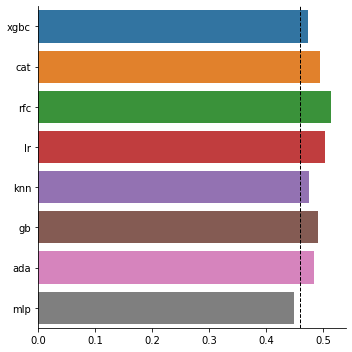

In [50]:
sns.catplot(data=scores.loc[['test']], kind='bar', orient='h', ci=False)
plt.axvline(0.459162, color='black', linestyle='--', linewidth=1)
plt.show()

In [43]:
df['winner'].value_counts(normalize=True)

0    0.459162
1    0.293249
2    0.247589
Name: winner, dtype: float64

|       |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 1        | 0.99297  | 1        | 0.557087 | 0.635546 | 0.676603 | 0.579584 | 0.832396 |
| test  | 0.472441 | 0.494751 | 0.513123 | 0.502625 | 0.475066 | 0.490814 | 0.48294  | 0.448819 |
| val   | 0.480996 | 0.504587 | 0.517693 | 0.533421 | 0.448231 | 0.519004 | 0.48886  | 0.44692  |

 
Total Time Spent: 170.92(s)


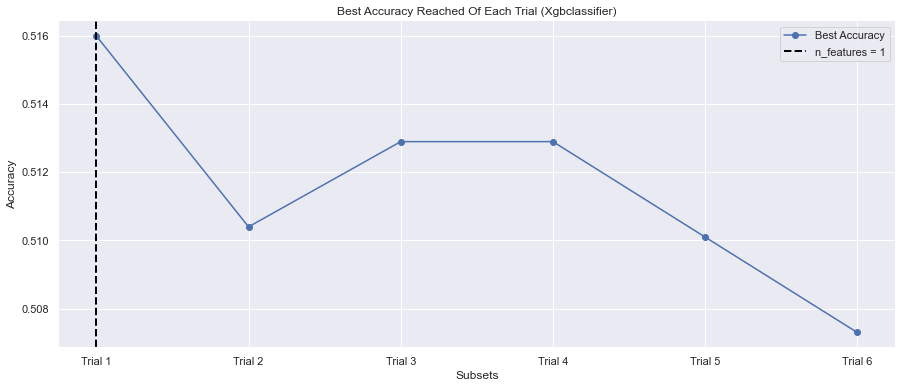

--------------------------------End of Recursive Features Selection (XGBClassifier)-------------------------------
 
Total Time Spent: 253.92(s)


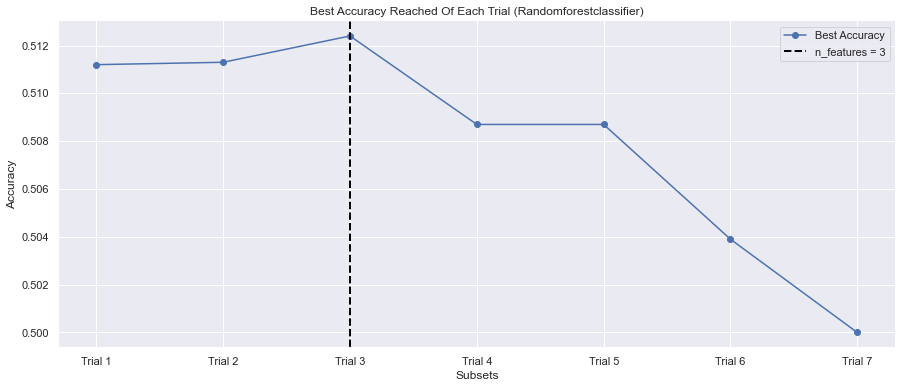

--------------------------------End of Recursive Features Selection (RandomForestClassifier)-------------------------------
 
Total Time Spent: 1593.28(s)


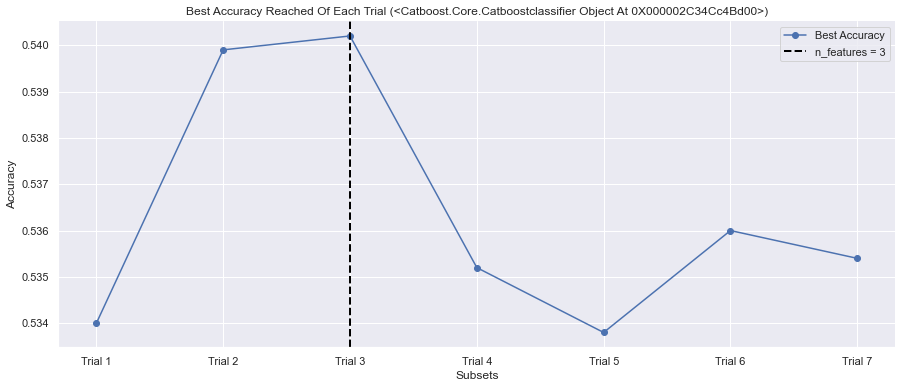

--------------------------------End of Recursive Features Selection (<catboost.core.CatBoostClassifier object at 0x000002C34CC4BD00>)-------------------------------
 
Total Time Spent: 1616.48(s)


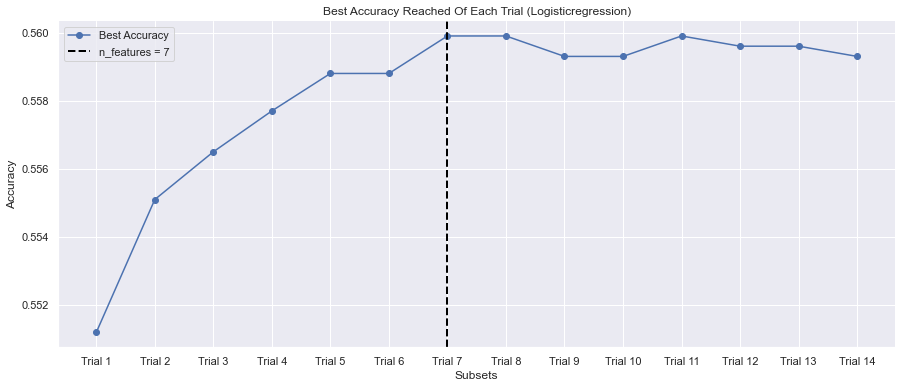

--------------------------------End of Recursive Features Selection (LogisticRegression)-------------------------------
 
Total Time Spent: 1651.41(s)


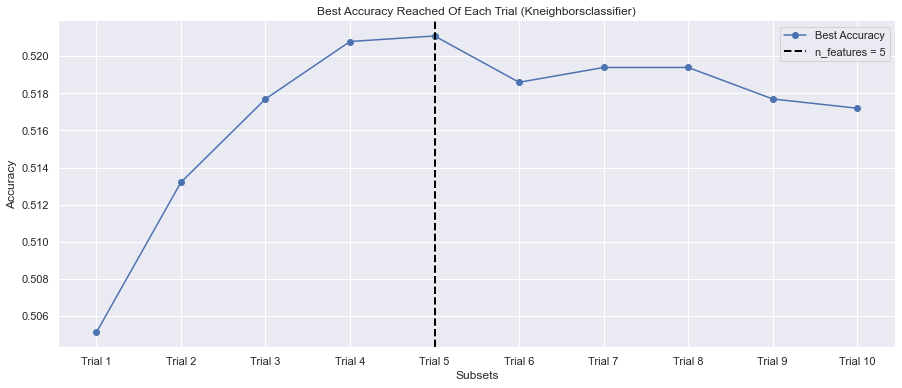

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Total Time Spent: 1878.56(s)


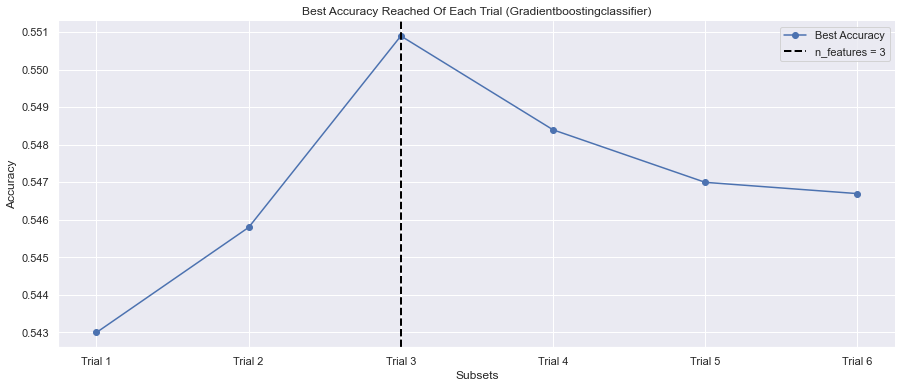

--------------------------------End of Recursive Features Selection (GradientBoostingClassifier)-------------------------------
 
Total Time Spent: 1945.82(s)


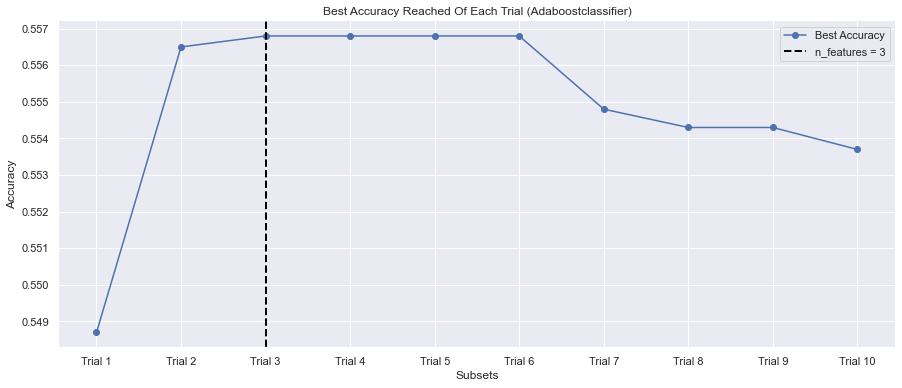

--------------------------------End of Recursive Features Selection (AdaBoostClassifier)-------------------------------
 
Total Time Spent: 2427.62(s)


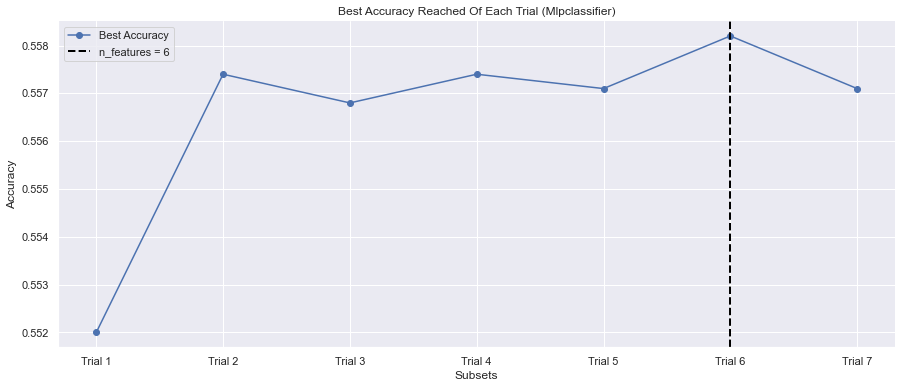

--------------------------------End of Recursive Features Selection (MLPClassifier)-------------------------------


In [53]:
# Instantiate the models
estimators = [
    XGBClassifier(use_label_encoder=False, verbosity=0), 
    RandomForestClassifier(n_jobs=-1),
    CatBoostClassifier(verbose=0), 
    LogisticRegression(n_jobs=-1), 
    KNeighborsClassifier(n_jobs=-1), 
    GradientBoostingClassifier(), 
    AdaBoostClassifier(), 
    MLPClassifier()
]

rfs = RecursiveFeatureSelector.RecursiveFeatureSelector()
rfs.fit(X_train, y_train)
rfs.search(estimators, cv=3, scoring='accuracy', verbose=1, tolerance=3)

In [54]:
rfs.summaries

{'XGBClassifier':                                                Best Subset Best Accuracy  \
 Trial 1                                     [away_team_en]         0.516   
 Trial 2                      [away_team_en, a_draw_streak]        0.5104   
 Trial 3  [away_team_en, a_draw_streak, h_match_specific...        0.5129   
 Trial 4  [away_team_en, a_draw_streak, h_match_specific...        0.5129   
 Trial 5  [away_team_en, a_draw_streak, h_match_specific...        0.5101   
 Trial 6  [away_team_en, a_draw_streak, h_match_specific...        0.5073   
 
         Time Spent  
 Trial 1      24.93  
 Trial 2      29.06  
 Trial 3      28.96  
 Trial 4      29.06  
 Trial 5      29.21  
 Trial 6       29.7  ,
 'RandomForestClassifier':                                                Best Subset Best Accuracy  \
 Trial 1                                     [away_team_en]        0.5112   
 Trial 2       [away_team_en, h_match_specific_draw_streak]        0.5113   
 Trial 3  [away_team_en, h_mat

In [55]:
rfs.best_subsets

{'XGBClassifier': ['away_team_en'],
 'RandomForestClassifier': ['away_team_en',
  'h_match_specific_draw_streak',
  'h_lose_streak'],
 '<catboost.core.CatBoostClassifier object at 0x000002C34CC4BD00>': ['odd_spread',
  'h_match_specific_draw_streak',
  'h_draw_streak'],
 'LogisticRegression': ['odd_spread',
  'h_lose_counts',
  'month',
  'h_lose_streak_ewm',
  'a_win_streak_ewm',
  'h_match_specific_win_streak',
  'h_lose_streak'],
 'KNeighborsClassifier': ['odd_spread',
  'month_sin',
  'h_match_specific_lose_counts',
  'a_draw_streak',
  'a_match_specific_lose_counts'],
 'GradientBoostingClassifier': ['h_odd', 'a_draw_streak_ewm', 'month'],
 'AdaBoostClassifier': ['h_to_a_odd_ratio',
  'h_match_specific_lose_counts',
  'h_match_specific_draw_streak'],
 'MLPClassifier': ['odd_spread',
  'a_win_streak_ewm',
  'h_odd',
  'h_match_specific_draw_streak',
  'h_match_specific_draw_streak_ewm',
  'h_match_specific_win_streak']}

In [66]:
xgb_col = ['away_team_en']
rfc_col = ['away_team_en', 'h_match_specific_draw_streak', 'h_lose_streak']
cat_col = ['odd_spread', 'h_match_specific_draw_streak', 'h_draw_streak']
lr_col = ['odd_spread', 'h_lose_counts', 'month', 'h_lose_streak_ewm', 'a_win_streak_ewm', 'h_match_specific_win_streak', 'h_lose_streak']
knn_col = ['odd_spread', 'month_sin', 'h_match_specific_lose_counts', 'a_draw_streak', 'a_match_specific_lose_counts']
gbc_col = ['h_odd', 'a_draw_streak_ewm', 'month']
ada_col = ['h_to_a_odd_ratio', 'h_match_specific_lose_counts', 'h_match_specific_draw_streak']
mlp_col = ['odd_spread', 'a_win_streak_ewm', 'h_odd', 'h_match_specific_draw_streak', 'h_match_specific_draw_streak_ewm', 'h_match_specific_win_streak']

In [56]:
# Instantiate the models
estimators = [
    XGBClassifier(use_label_encoder=False, verbosity=0), 
    RandomForestClassifier(n_jobs=-1),
    CatBoostClassifier(verbose=0), 
    LogisticRegression(n_jobs=-1), 
    KNeighborsClassifier(n_jobs=-1), 
    GradientBoostingClassifier(), 
    AdaBoostClassifier(), 
    MLPClassifier()
]

scores_train = {}
scores_test = {}
scores_val = {}

for e, i in zip(estimators, rfs.best_subsets.items()):
    k = i[0]
    v = i[1]
    
    e.fit(X_train[v], y_train)
    
    y_pred_train = e.predict(X_train[v])
    y_pred_test = e.predict(X_test[v])
    y_pred_val = e.predict(X_val[v])
    
    acc_train = accuracy_score(y_pred_train, y_train)
    acc_test = accuracy_score(y_pred_test, y_test)
    acc_val = accuracy_score(y_pred_val, y_val)
    
    scores_train[k] = acc_train
    scores_test[k] = acc_test
    scores_val[k] = acc_val
    
scores = pd.DataFrame([scores_train, scores_test, scores_val], index=['train', 'test', 'val'])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

In [57]:
print(scores.to_markdown())

|       |   XGBClassifier |   RandomForestClassifier |   <catboost.core.CatBoostClassifier object at 0x000002C34CC4BD00> |   LogisticRegression |   KNeighborsClassifier |   GradientBoostingClassifier |   AdaBoostClassifier |   MLPClassifier |
|:------|----------------:|-------------------------:|------------------------------------------------------------------:|---------------------:|-----------------------:|-----------------------------:|---------------------:|----------------:|
| train |        0.519685 |                 0.546119 |                                                          0.603487 |             0.558211 |               0.652137 |                     0.604049 |             0.560742 |        0.557368 |
| test  |        0.496063 |                 0.463255 |                                                          0.480315 |             0.52231  |               0.47769  |                     0.514436 |             0.506562 |        0.519685 |
| val   |        0.505898 | 

|naive  |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 1        | 0.99297  | 1        | 0.557087 | 0.635546 | 0.676603 | 0.579584 | 0.832396 |
| test  | 0.472441 | 0.494751 | 0.513123 | 0.502625 | 0.475066 | 0.490814 | 0.48294  | 0.448819 |
| val   | 0.480996 | 0.504587 | 0.517693 | 0.533421 | 0.448231 | 0.519004 | 0.48886  | 0.44692  |
|rfs    |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
| train | 0.519685 | 0.546119 | 0.603487 | 0.558211 | 0.652137 | 0.604049 | 0.560742 | 0.557368 |
| test  | 0.496063 | 0.463255 | 0.480315 | 0.52231  | 0.47769  | 0.514436 | 0.506562 | 0.519685 |
| val   | 0.505898 | 0.500655 | 0.534731 | 0.545216 | 0.501966 | 0.525557 | 0.528178 | 0.547837 |

In [67]:
opt = BayesSearchCV(
     XGBClassifier(use_label_encoder=False, verbosity=0),
     {
     'n_estimators': Integer(1, 10000),
     'learning_rate': Real(1e-6, 1, prior='log-uniform'),
     'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
     },
     cv=3,
     scoring="accuracy"
)

opt.fit(X_train[xgb_col], y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[xgb_col], y_train))
print("Test score: %s" % opt.score(X_test[xgb_col], y_test))
print("Validation score: %s" % opt.score(X_val[xgb_col], y_val))
print("best params: %s" % str(opt.best_params_))

# naive
# CV score: 0.5514642227772204
# Train score: 0.5655230596175478
# Test score: 0.5183727034120735
# Validation score: 0.5321100917431193
# best params: OrderedDict([('gamma', 10.0), ('learning_rate', 0.8669288936481925), ('n_estimators', 7771)])

# CV score: 0.5177191472002238
# Train score: 0.5196850393700787
# Test score: 0.49606299212598426
# Validation score: 0.5058977719528178
# best params: OrderedDict([('gamma', 0.0003223504462338463), ('learning_rate', 0.0042079490949710465), ('n_estimators', 539)])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

CV score: 0.5177191472002238
Train score: 0.5196850393700787
Test score: 0.49606299212598426
Validation score: 0.5058977719528178
best params: OrderedDict([('gamma', 0.0003223504462338463), ('learning_rate', 0.0042079490949710465), ('n_estimators', 539)])


C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [68]:
opt = BayesSearchCV(
 RandomForestClassifier(n_jobs=-1),
 {
 'n_estimators': Integer(1, 10000),
 'criterion': Categorical(['gini', 'entropy']),
 'max_depth': Integer(1,16)
 },
 cv=3,
 scoring="accuracy"
)

opt.fit(X_train[rfc_col], y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[rfc_col], y_train))
print("Test score: %s" % opt.score(X_test[rfc_col], y_test))
print("Validation score: %s" % opt.score(X_val[rfc_col], y_val))
print("best params: %s" % str(opt.best_params_))


# naive
# CV score: 0.5492141083384919
# Train score: 0.5590551181102362
# Test score: 0.5223097112860893
# Validation score: 0.5360419397116645
# best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 4), ('n_estimators', 2416)])

# CV score: 0.5126572791332541
# Train score: 0.5441507311586051
# Test score: 0.4671916010498688
# Validation score: 0.4927916120576671
# best params: OrderedDict([('criterion', 'gini'), ('max_depth', 10), ('n_estimators', 10000)])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV score: 0.5126572791332541
Train score: 0.5441507311586051
Test score: 0.4671916010498688
Validation score: 0.4927916120576671
best params: OrderedDict([('criterion', 'gini'), ('max_depth', 10), ('n_estimators', 10000)])


In [71]:
opt = BayesSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    {
    'n_neighbors': Integer(1, X_val.shape[1]),
    'leaf_size': Integer(2, 50),
    'weights': Categorical(['uniform', 'distance']),
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train[knn_col], y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[knn_col], y_train))
print("Test score: %s" % opt.score(X_test[knn_col], y_test))
print("Validation score: %s" % opt.score(X_val[knn_col], y_val))
print("best params: %s" % str(opt.best_params_))


# naive
# CV score: 0.5219380821255007
# Train score: 0.5357142857142857
# Test score: 0.48031496062992124
# Validation score: 0.5163826998689384
# best params: OrderedDict([('leaf_size', 2), ('n_neighbors', 72), ('weights', 'uniform')])

# CV score: 0.538810501324643
# Train score: 0.5545556805399325
# Test score: 0.5
# Validation score: 0.5255570117955439
# best params: OrderedDict([('leaf_size', 50), ('n_neighbors', 63), ('weights', 'uniform')])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV score: 0.538810501324643
Train score: 0.5545556805399325
Test score: 0.5
Validation score: 0.5255570117955439
best params: OrderedDict([('leaf_size', 50), ('n_neighbors', 63), ('weights', 'uniform')])


In [65]:
opt = BayesSearchCV(
    CatBoostClassifier(verbose=0),
    {
    'n_estimators': Integer(1, 10000),
    'learning_rate': Real(1e-4, 0.1, prior='log-uniform'),
    'max_depth': Integer(1,16)
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train, y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train, y_train))
print("Test score: %s" % opt.score(X_test, y_test))
print("Validation score: %s" % opt.score(X_val, y_val))
print("best params: %s" % str(opt.best_params_))

KeyboardInterrupt: 

In [69]:
opt = BayesSearchCV(
    LogisticRegression(verbose=0, n_jobs=5),
    {
    'penalty':Categorical(['l2', 'none']),
    'C': Real(1e-6, 10, prior='log-uniform'),
    'max_iter': Integer(100, 10000),
    'l1_ratio': Real(1e-6, 1)
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train[lr_col], y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[lr_col], y_train))
print("Test score: %s" % opt.score(X_test[lr_col], y_test))
print("Validation score: %s" % opt.score(X_val[lr_col], y_val))
print("best params: %s" % str(opt.best_params_))

# naive
# CV score: 0.5447150653545941
# Train score: 0.5545556805399325
# Test score: 0.5131233595800525
# Validation score: 0.528178243774574
# best params: OrderedDict([('C', 0.0015490292915730007), ('l1_ratio', 1.0), ('max_iter', 10000), ('penalty', 'l2')])

# CV score: 0.5599016182703505
# Train score: 0.5582114735658043
# Test score: 0.5223097112860893
# Validation score: 0.54521625163827
# best params: OrderedDict([('C', 1.2836329467093133), ('l1_ratio', 0.9210820209474683), ('max_iter', 8630), ('penalty', 'none')])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: Us

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: User

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: Us

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parame

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: Us

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parame

CV score: 0.5599016182703505
Train score: 0.5582114735658043
Test score: 0.5223097112860893
Validation score: 0.54521625163827
best params: OrderedDict([('C', 1.2836329467093133), ('l1_ratio', 0.9210820209474683), ('max_iter', 8630), ('penalty', 'none')])


C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [70]:
opt = BayesSearchCV(
    MLPClassifier(),
    {
    'hidden_layer_sizes':Integer(1, 10000),
    'learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
    'activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
    'solver': Categorical(['adam']),
    'max_iter': Integer(1, 10000)
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train[mlp_col], y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[mlp_col], y_train))
print("Test score: %s" % opt.score(X_test[mlp_col], y_test))
print("Validation score: %s" % opt.score(X_val[mlp_col], y_val))
print("best params: %s" % str(opt.best_params_))

# naive
# CV score: 0.5478083501137273
# Train score: 0.5525871766029247
# Test score: 0.510498687664042
# Validation score: 0.5307994757536042
# best params: OrderedDict([
#     ('activation', 'identity'), 
#     ('hidden_layer_sizes', 1), 
#     ('learning_rate', 'adaptive'), 
#     ('max_iter', 10000), 
#     ('solver', 'adam')
# ])

# CV score: 0.5551203326194254
# Train score: 0.5528683914510686
# Test score: 0.526246719160105
# Validation score: 0.5386631716906947
# best params: OrderedDict([
#     ('activation', 'tanh'), 
#     ('hidden_layer_sizes', 10000), 
#     ('learning_rate', 'invscaling'), 
#     ('max_iter', 3589), 
#     ('solver', 'adam')
# ])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization ha

CV score: 0.5551203326194254
Train score: 0.5528683914510686
Test score: 0.526246719160105
Validation score: 0.5386631716906947
best params: OrderedDict([('activation', 'tanh'), ('hidden_layer_sizes', 10000), ('learning_rate', 'invscaling'), ('max_iter', 3589), ('solver', 'adam')])


In [73]:
xgbc = XGBClassifier(
    use_label_encoder=False, 
    verbosity=0,
    gamma=10,
    learning_rate=0.8669288936481925,
    n_estimators=7771
    )

cat = CatBoostClassifier(verbose=0)

rfc = RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=2416)

lr = LogisticRegression()

knn = KNeighborsClassifier(leaf_size=50, n_neighbors=63, weights='uniform')

gbc = GradientBoostingClassifier()

ada = AdaBoostClassifier()

mlp = MLPClassifier(
    activation='tanh', 
    hidden_layer_sizes=10000, 
    learning_rate='invscaling',
    max_iter=3589, 
    solver='adam'
)


xgbc.fit(X_train, y_train)
cat.fit(X_train, y_train)
rfc.fit(X_train, y_train)
lr.fit(X_train[lr_col], y_train)
knn.fit(X_train[knn_col], y_train)
gbc.fit(X_train, y_train)
ada.fit(X_train, y_train)
mlp.fit(X_train[mlp_col], y_train)

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MLPClassifier(activation='tanh', hidden_layer_sizes=10000,
              learning_rate='invscaling', max_iter=3589)

In [74]:
y_pred_xgbc = xgbc.predict(X_test)
y_pred_cat = cat.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_lr = lr.predict(X_test[lr_col])
y_pred_knn = knn.predict(X_test[knn_col])
y_pred_gb = gbc.predict(X_test)
y_pred_ada = ada.predict(X_test)
y_pred_mlp = mlp.predict(X_test[mlp_col])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


|naive  |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 1        | 0.99297  | 1        | 0.557087 | 0.635546 | 0.676603 | 0.579584 | 0.832396 |
| test  | 0.472441 | 0.494751 | 0.513123 | 0.502625 | 0.475066 | 0.490814 | 0.48294  | 0.448819 |
| val   | 0.480996 | 0.504587 | 0.517693 | 0.533421 | 0.448231 | 0.519004 | 0.48886  | 0.44692  |
|rfs    |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
| train | 0.519685 | 0.546119 | 0.603487 | 0.558211 | 0.652137 | 0.604049 | 0.560742 | 0.557368 |
| test  | 0.496063 | 0.463255 | 0.480315 | 0.52231  | 0.47769  | 0.514436 | 0.506562 | 0.519685 |
| val   | 0.505898 | 0.500655 | 0.534731 | 0.545216 | 0.501966 | 0.525557 | 0.528178 | 0.547837 |
|hy     |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
| train | 0.565523 | -------- | 0.559055 | 0.554555 | 0.535714 | -------- | -------- | 0.552587 |
| test  | 0.518372 | -------- | 0.522309 | 0.513123 | 0.480314 | -------- | -------- | 0.510498 |
| val   | 0.532110 | -------- | 0.536041 | 0.52817  | 0.516382 | -------- | -------- | 0.530799 |
|hy+rfs |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
| train | 0.519685 | -------- | 0.544150 | 0.558211 | 0.554555 | -------- | -------- | 0.552868 |
| test  | 0.496062 | -------- | 0.467191 | 0.522309 | 0.5      | -------- | -------- | 0.526246 |
| val   | 0.505897 | -------- | 0.492791 | 0.5452   | 0.525557 | -------- | -------- | 0.538663 |

# Save Models

In [81]:
pickle.dump(rfc, open('save/rfc_premier_league.sav', 'wb'))
pickle.dump(cat, open('save/cat_premier_league.sav', 'wb'))
pickle.dump(ada, open('save/ada_premier_league.sav', 'wb'))
pickle.dump(mlp, open('save/mlp_premier_league.sav', 'wb'))

# Backtesting

In [82]:
def P_and_L(y_pred):
    real_odds = []
    for i in y_val.astype(int):
        if i == 0:
            real_odds.append(df[N:]['h_odd'].to_list()[i])

        elif i == 1:
            real_odds.append(df[N:]['a_odd'].to_list()[i])

        elif i == 2:
            real_odds.append(df[N:]['d_odd'].to_list()[i])
    
    try:
        correct_prediction = y_pred.to_numpy() == y_val.to_numpy()
        
    except:
        correct_prediction = y_pred == y_val.to_numpy()
        
    P = np.array(real_odds)[correct_prediction].astype(float).sum() * 100
    L = (~correct_prediction).sum() * 100
    
    P_and_L_cumsum = np.where(correct_prediction, np.array(real_odds), -1)
    P_and_L_cumsum = pd.Series(P_and_L_cumsum).astype(float).cumsum()
    
    miu = np.where(correct_prediction, np.array(real_odds), -1).astype(float).mean()
    sigma = np.where(correct_prediction, np.array(real_odds), -1).astype(float).std()
    acc = correct_prediction.sum() / len(correct_prediction)
    
    return P, L, P_and_L_cumsum, miu, sigma, acc

In [106]:
y_pred_cat = cat.predict(X_val)
y_pred_rfc = rfc.predict(X_val)
y_pred_ada = ada.predict(X_val)
y_pred_mlp = mlp.predict(X_val[mlp_col])
y_pred = pd.DataFrame(np.vstack([y_pred_rfc, y_pred_cat.reshape((763, )), y_pred_ada, y_pred_mlp]).T).mode(axis=1)[0]

In [107]:
P, L, P_and_L_cumsum, miu, sigma, acc = P_and_L(y_pred)

In [115]:
base_line_acc = sum(np.zeros(len(y_test)) == y_test.to_numpy())/len(y_test)
sharpe_ratio = miu/sigma
ret_pct = ((P - L)/L * 100) / 763


    Total Profit:    63346
    Total Loss:      34900
    Expected Return: 0.373
    Risk:            1.265
    Accuracy:        0.543
    %Return:         0.107
    


<AxesSubplot:>

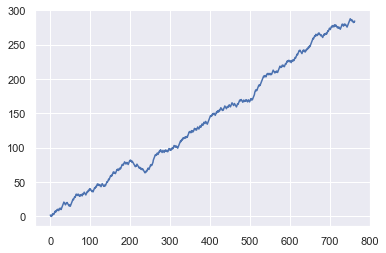

In [116]:
print(
    f'''
    Total Profit:    {round(P)}
    Total Loss:      {L}
    Expected Return: {round(miu, 3)}
    Risk:            {round(sigma, 3)}
    Accuracy:        {round(acc, 3)}
    %Return:         {round(ret_pct, 3)}
    '''
)

P_and_L_cumsum.plot()

# Total Profit:    63346
# Total Loss:      34900
# Expected Return: 0.373
# Risk:            1.265
# Accuracy:        0.543
# %Return:         20.377